In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
with open('results.txt') as f:
    b = f.readlines()

In [3]:
reactions = []
species = []
classic = [] # microseconds
jits = [] # microseconds
preproc = [] # microseconds
jit_compile_time = [] # microseconds

for idx, line in enumerate(b):
    if idx % 5 == 0:
        [react, spec] = line.strip().split(';')
        reactions.append(int(react.split(':')[1]))
        species.append(int(spec.split(':')[1]))
    elif idx % 5 == 1:
        [clas, jit, pre] = line.strip().split(';')
        classic.append(int(clas.split(':')[1]))
        jits.append(int(jit.split(':')[1]))
        preproc.append(int(pre.split(':')[1]))
    elif idx % 5 == 4:
        comptime = line.strip().split(':')
        jit_compile_time.append(int(comptime[1]))
    else:
        pass                

In [4]:
preproc_comptime = [] # microseconds
for spec, reac in zip(species, reactions):
    comp = pd.read_json(f'data/cmake_build_trace_nreact_{reac}_nspecies_{spec}.json')[['name', 'dur']]
    preproc_comptime.append(
        (comp[comp['name'].str.contains('test/derivative/mod.mod')]).dur.item()
    )


In [35]:
results = pd.DataFrame({
    'Reactions': reactions[:len(preproc_comptime)],
    'Species': species[:len(preproc_comptime)],
    'Classic': classic[:len(preproc_comptime)],
    'JIT': jits[:len(preproc_comptime)],
    'Preprocessed': preproc[:len(preproc_comptime)],
    'JIT Compile Time': jit_compile_time[:len(preproc_comptime)],
    'Preprocessed Compile Time': preproc_comptime[:len(preproc_comptime)]
})

In [36]:
df = pd.read_csv('data/python_jit.csv')

In [37]:
results = pd.concat([results, df.drop(columns=['reactions', 'species'])], axis=1)

In [38]:
results['JIT Speedup'] = results.Classic / results.JIT
results['Preprocessed Speedup'] = results.Classic / results.Preprocessed
results['Python JIT Speedup'] = results.Classic / results['Python JIT Time']

In [39]:
results

,Reactions,Species,Classic,JIT,Preprocessed,JIT Compile Time,Preprocessed Compile Time,Python Classic Time,Python JIT Time,Python JIT Compile Time,JIT Speedup,Preprocessed Speedup,Python JIT Speedup
0,10,10,562,95,62,8878,77000,269505.0,6738.0,102808.0,5.915789,9.064516,0.083408
1,10,100,611,135,186,9875,75000,262275.0,6738.0,13.0,4.525926,3.284946,0.090680
2,10,500,819,133,566,8736,98000,270640.0,6987.0,8.0,6.157895,1.446996,0.117218
3,10,1000,1301,129,991,8687,76000,271780.0,7245.0,9.0,10.085271,1.312815,0.179572
4,10,1500,2130,151,1779,9246,83000,271577.0,7798.0,5.0,14.105960,1.197302,0.273147
5,10,2000,2615,137,2218,9165,82000,275009.0,8174.0,32.0,19.087591,1.178990,0.319917
6,100,10,7567,1082,980,238217,164000,2510163.0,15928.0,53.0,6.993530,7.721429,0.475075
7,100,100,5072,1664,1932,301017,626000,2499899.0,14171.0,40.0,3.048077,2.625259,0.357914
8,100,500,6060,1619,1741,264615,783000,2630217.0,14597.0,63.0,3.743051,3.480758,0.415154
9,100,1000,5814,1572,2147,329954,794000,2618920.0,14845.0,46.0,3.698473,2.707965,0.391647


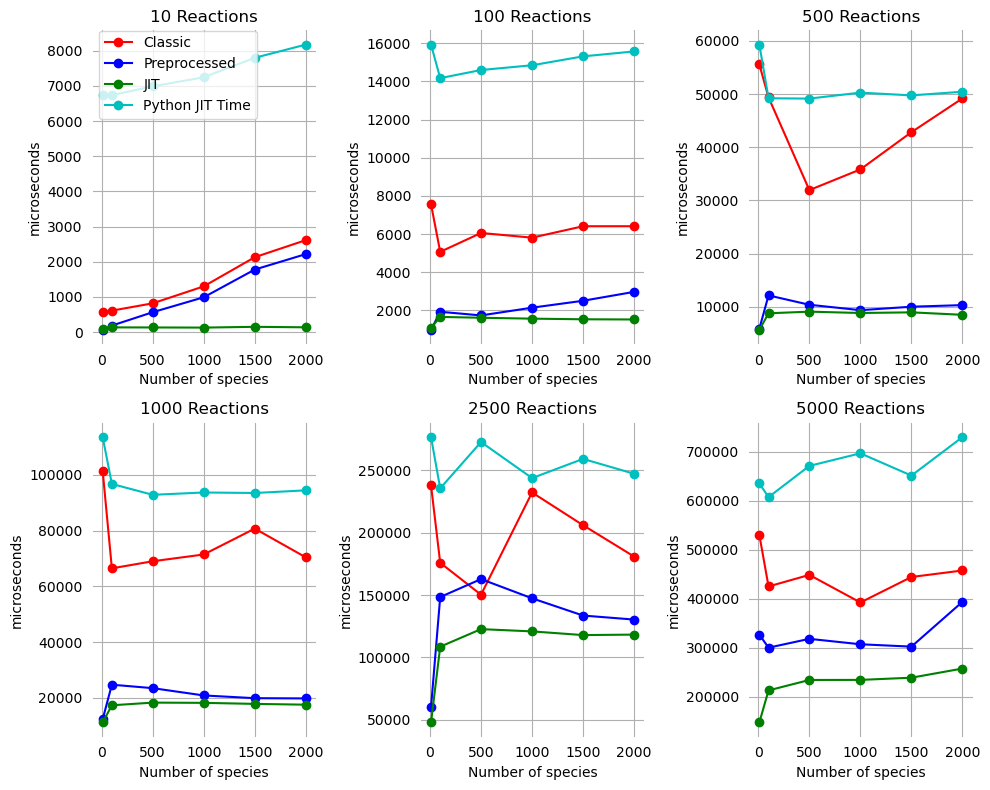

In [40]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 8))

for nreacts, ax in zip(results.Reactions.unique(), axes.ravel()):
    _sub = results[results.Reactions == nreacts]
    for column, color in [('Classic', 'r'), ('Preprocessed', 'b'), ('JIT', 'g'), ('Python JIT Time', 'c')]:
        ax.plot(_sub.Species, _sub[column], color=color, label=column, marker='o')

    ax.set_ylabel('microseconds')
    ax.set_xlabel('Number of species')
    ax.set_title(f'{nreacts} Reactions')
    ax.spines[:].set_visible(False)
    ax.grid()
    ax.tick_params(width=0, which='both')
    
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc = (0.1, 0.85))
fig.tight_layout()

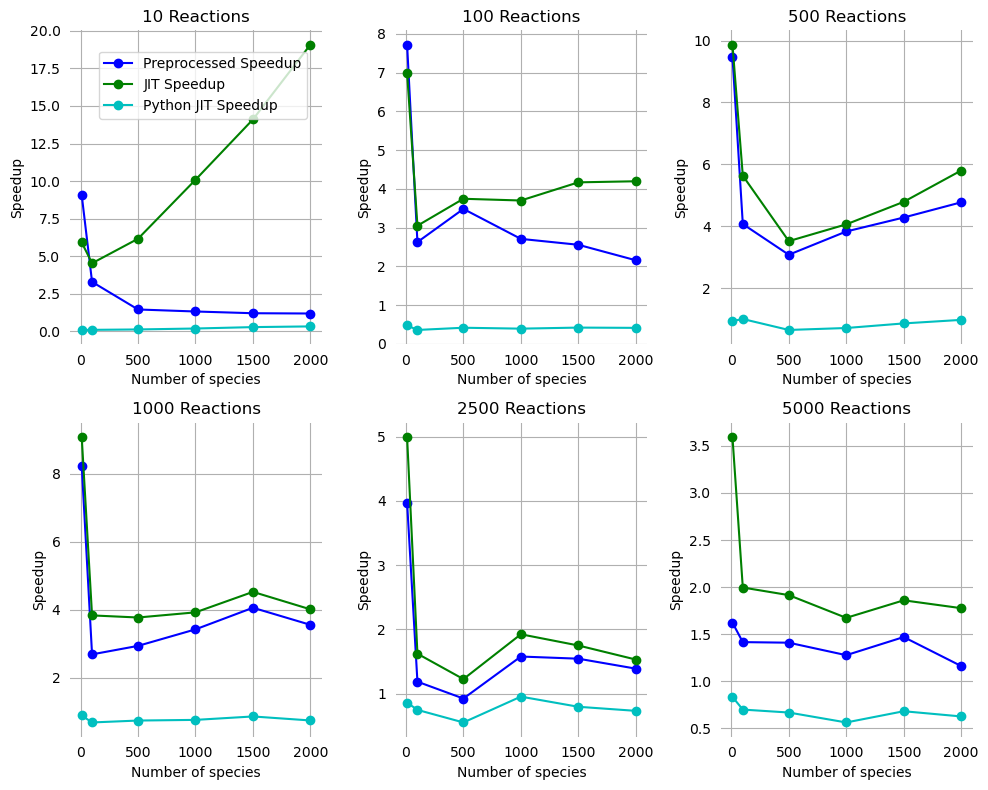

In [41]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 8))

for nreacts, ax in zip(results.Reactions.unique(), axes.ravel()):
    _sub = results[results.Reactions == nreacts]
    for column, color in [('Preprocessed Speedup', 'b'), ('JIT Speedup', 'g'), ('Python JIT Speedup', 'c')]:
        ax.plot(_sub.Species, _sub[column], color=color, label=column, marker='o')
        
#     for _, (species, runtime, comptime) in _sub[['Species', 'JIT Speedup', 'JIT Compile Time']].iterrows():
#         ax.annotate(
#             text=f'{comptime/1e6:.2f} s', 
#             xy=(species, runtime), 
#             xytext=(5, 3), 
#             textcoords="offset pixels",
#             fontsize=8
#         )
        
#     for _, (species, runtime, comptime) in _sub[['Species', 'Preprocessed Speedup', 'Preprocessed Compile Time']].iterrows():
#         ax.annotate(
#             text=f'{comptime/1e6:.2f} s', 
#             xy=(species, runtime), 
#             xytext=(5, 3), 
#             textcoords="offset pixels",
#             fontsize=8
#         )

    ax.set_ylabel('Speedup')
    ax.set_xlabel('Number of species')
    ax.set_title(f'{nreacts} Reactions')
    ax.spines[:].set_visible(False)
    ax.grid()
    ax.tick_params(width=0, which='both')
    
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc = (0.1, 0.85))
fig.tight_layout()

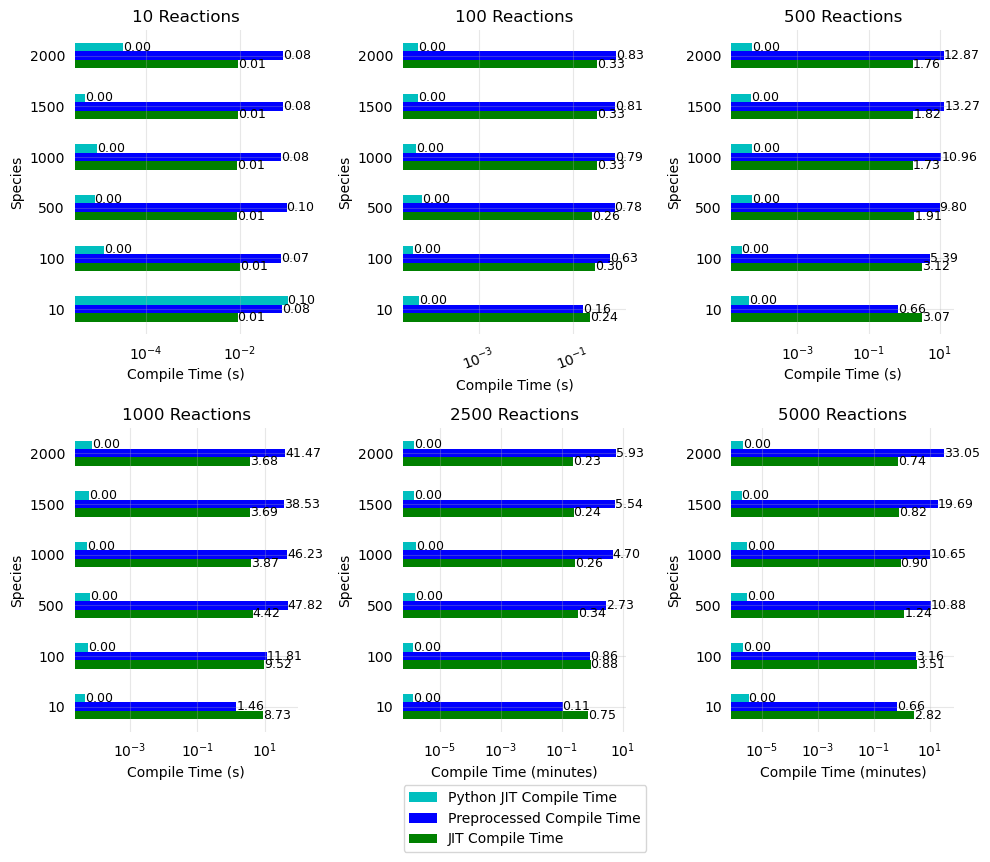

In [42]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 8))

for nreacts, ax in zip(results.Reactions.unique(), axes.ravel()):
    _sub = results[results.Reactions == nreacts]
    _sub = _sub.set_index('Species')[
        ['JIT Compile Time', 'Preprocessed Compile Time', 'Python JIT Compile Time']
    ]
    
    if nreacts >= 2500:
        _sub /= 60 # convert to minutes
    _sub /= 1e6
    bars = _sub.plot.barh(ax=ax, legend=False, color=['g', 'b', 'c'])
    
    for patch in ax.patches:
        bl = patch.get_xy()
        x = patch.get_width() + bl[0]
        y = 0.5*patch.get_height() + bl[1]
        ax.text(x, y, 
                f'{patch.get_width():0.2f}', 
                fontsize=9, 
                ha='left',
                va='center',
                color='black')

        
    ax.set_yticklabels(_sub.index.values)

    ax.set_title(f'{nreacts} Reactions')
    ax.set_ylabel('Species')
    
    if nreacts >= 2500:
        ax.set_xlabel('Compile Time (minutes)')
    else:
        ax.set_xlabel('Compile Time (s)')
    
    ax.set_xscale('log')
    ax.spines[:].set_visible(False)
    ax.grid(which='both', alpha=0.3)
    ax.tick_params(width=0, which='both')

axes.ravel()[1].tick_params(axis='x', which='both', rotation=20)

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles[::-1], labels[::-1], loc='lower center', bbox_to_anchor=(0.53, -0.08))
fig.tight_layout()